In [20]:
from synthetix_v3.base_perps import BasePerps
from datetime import datetime
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
base_perp = BasePerps()
df = base_perp.get_position_liquidations()

In [10]:
# convert column to float
df['positionLiquidateds_accountId'] = df['positionLiquidateds_accountId'].astype(float)
df['positionLiquidateds_amountLiquidated'] = df['positionLiquidateds_amountLiquidated'].astype(float)
df['positionLiquidateds_currentPositionSize'] = df['positionLiquidateds_currentPositionSize'].astype(float)

In [13]:
polars_df = pl.from_pandas(df)

In [15]:
polars_df = polars_df.with_columns([
    pl.from_epoch('positionLiquidateds_timestamp').dt.round('1d').alias('datetime'),
    pl.col('positionLiquidateds_amountLiquidated') / 10**18,
    pl.col('positionLiquidateds_currentPositionSize') / 10**18,
    ])

In [21]:
grouped_df = polars_df.sort(by='datetime', descending=True).with_columns(pl.col('datetime').dt.round('1d')).group_by('datetime', 'markets_marketSymbol').agg([pl.count()]).filter(pl.col('datetime') > datetime(2023, 10, 2)).to_pandas()

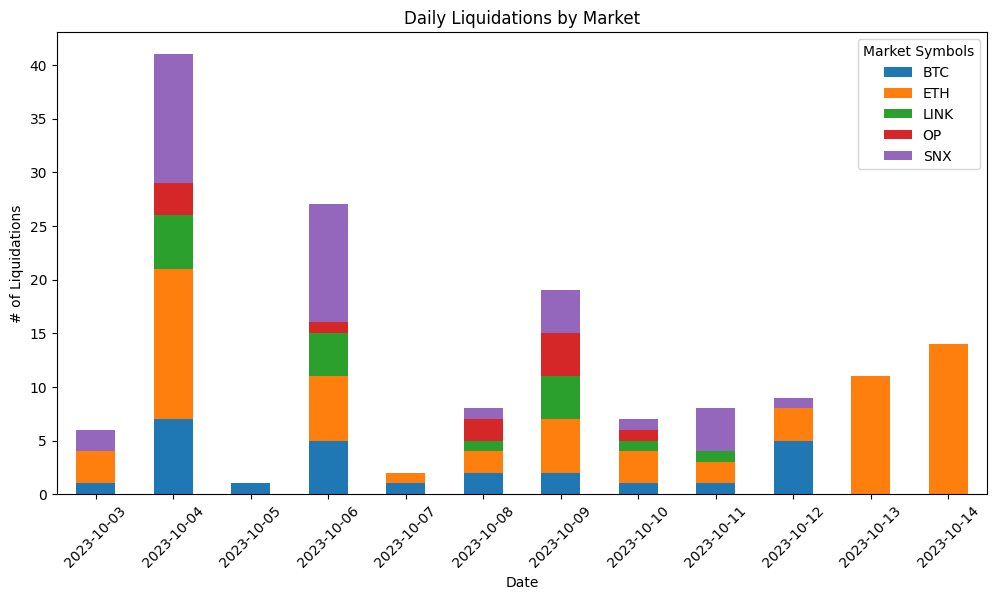

In [24]:
# Pivot the DataFrame to create a stacked bar plot
pivot_df = grouped_df.pivot(index='datetime', columns='markets_marketSymbol', values='count').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel("Date")
ax.set_ylabel("# of Liquidations")
ax.set_title("Daily Liquidations by Market")

# Format the x-axis labels to display only the date
date_format = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_format)

plt.xticks(range(len(pivot_df.index)), [ts.strftime('%Y-%m-%d') for ts in pivot_df.index], rotation=45)
plt.legend(title="Market Symbols")
plt.show()